In [1]:
import os
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from rasterio.plot import show
from rasterio.transform import from_origin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

# CONSTANTS

In [2]:
SAMPLE_INPUT_PATH = '../datasets/samples'

AWAN_SAMPLE_PATH = os.path.join(SAMPLE_INPUT_PATH, 'Sample_Awan.csv')
BADAN_AIR_SAMPLE_PATH = os.path.join(SAMPLE_INPUT_PATH, 'Sample_BadanAir.csv')
PEMUKIMAN_SAMPLE_PATH = os.path.join(SAMPLE_INPUT_PATH, 'Sample_Pemukiman.csv')
PERKEBUNAN_SAMPLE_PATH = os.path.join(SAMPLE_INPUT_PATH, 'Sample_Perkebunan.csv')
PERTANIAN_SAMPLE_PATH = os.path.join(SAMPLE_INPUT_PATH, 'Sample_Pertanian.csv')
RERUMPUTAN_SAMPLE_PATH = os.path.join(SAMPLE_INPUT_PATH, 'Sample_Rerumputan.csv')

In [3]:
AWAN_SAMPLE_PATH

'../datasets/samples/Sample_Awan.csv'

# EDA

In [4]:
awan_df = pd.read_csv(AWAN_SAMPLE_PATH)
awan_df['class'] = 'awan'

badan_air_df = pd.read_csv(BADAN_AIR_SAMPLE_PATH)
badan_air_df['class'] = 'badan air'

pemukiman_df = pd.read_csv(PEMUKIMAN_SAMPLE_PATH)
pemukiman_df['class'] = 'pemukiman'

perkebunan_df = pd.read_csv(PERKEBUNAN_SAMPLE_PATH)
perkebunan_df['class'] = 'perkebunan'

pertanian_df = pd.read_csv(PERTANIAN_SAMPLE_PATH)
pertanian_df['class'] = 'pertanian'

rerumputan_df = pd.read_csv(RERUMPUTAN_SAMPLE_PATH)
rerumputan_df['class'] = 'rerumputan'

In [5]:
train_df = pd.concat([awan_df, badan_air_df, pemukiman_df, rerumputan_df, perkebunan_df, pertanian_df], ignore_index=True)
train_df.head()

Raster_LC08_20200613_1  Raster_LC08_20200613_2  Raster_LC08_20200613_3  \
0                  0.5211                  0.5531                  0.5692   
1                  0.4891                  0.5115                  0.5593   
2                  0.6710                  0.7020                  0.7172   
3                  0.5485                  0.5690                  0.5841   
4                  0.3839                  0.4138                  0.4256   

   Raster_LC08_20200613_4  Raster_LC08_20200613_5  Raster_LC08_20200613_6  \
0                  0.5852                  0.7203                  0.6603   
1                  0.5788                  0.7050                  0.6441   
2                  0.7371                  0.8347                  0.7871   
3                  0.6042                  0.7024                  0.6574   
4                  0.4356                  0.5792                  0.4661   

   Raster_LC08_20200613_7 class  id  
0                  0.5347  awan NaN  
1                  0.5096  awan NaN  
2                  0.6619  awan NaN  
3                  0.5454  awan NaN  
4                  0.3701  awan NaN

In [6]:
train_df.drop(columns=['id'], inplace=True)
train_df.columns

Index(['Raster_LC08_20200613_1', 'Raster_LC08_20200613_2',
       'Raster_LC08_20200613_3', 'Raster_LC08_20200613_4',
       'Raster_LC08_20200613_5', 'Raster_LC08_20200613_6',
       'Raster_LC08_20200613_7', 'class'],
      dtype='object')

In [7]:
train_df.rename(
    columns={
        'Raster_LC08_20200613_1': 'B1',
        'Raster_LC08_20200613_2': 'B2',
        'Raster_LC08_20200613_3': 'B3',
        'Raster_LC08_20200613_4': 'B4',
        'Raster_LC08_20200613_5': 'B5',
        'Raster_LC08_20200613_6': 'B6',
        'Raster_LC08_20200613_7': 'B7'
    },
    inplace=True
)
train_df.head()

B1      B2      B3      B4      B5      B6      B7 class
0  0.5211  0.5531  0.5692  0.5852  0.7203  0.6603  0.5347  awan
1  0.4891  0.5115  0.5593  0.5788  0.7050  0.6441  0.5096  awan
2  0.6710  0.7020  0.7172  0.7371  0.8347  0.7871  0.6619  awan
3  0.5485  0.5690  0.5841  0.6042  0.7024  0.6574  0.5454  awan
4  0.3839  0.4138  0.4256  0.4356  0.5792  0.4661  0.3701  awan

In [8]:
train_df.isna().sum()

B1       0
B2       0
B3       0
B4       0
B5       0
B6       0
B7       0
class    0
dtype: int64

In [9]:
train_df = train_df.dropna()

In [10]:
train_df.describe()

B1           B2           B3           B4           B5  \
count  1495.000000  1495.000000  1495.000000  1495.000000  1495.000000   
mean      0.031671     0.036426     0.060121     0.049828     0.291521   
std       0.055750     0.060546     0.064836     0.071027     0.119034   
min       0.000000     0.000000     0.011200     0.003000     0.007500   
25%       0.012900     0.016500     0.036650     0.024000     0.195200   
50%       0.019000     0.022400     0.049500     0.032100     0.312100   
75%       0.024450     0.028000     0.060200     0.044400     0.348600   
max       0.671000     0.702000     0.717200     0.737100     0.834700   

                B6           B7  
count  1495.000000  1495.000000  
mean      0.160800     0.085649  
std       0.086417     0.076630  
min       0.002500     0.001700  
25%       0.120050     0.045100  
50%       0.142000     0.056300  
75%       0.207400     0.103750  
max       0.787100     0.661900

In [11]:
train_df['class'].value_counts()

class
perkebunan    379
pertanian     300
rerumputan    265
pemukiman     250
badan air     221
awan           80
Name: count, dtype: int64

# Model 1: Awan & Badan Air VS Others

In [12]:
train_df['new_class'] = np.where((train_df['class'] == 'awan' )| (train_df['class'] == 'badan air'), 1, 0)
train_df['new_class'].value_counts()

new_class
0    1194
1     301
Name: count, dtype: int64

In [13]:
train_df.columns[0:-2]

Index(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'], dtype='object')

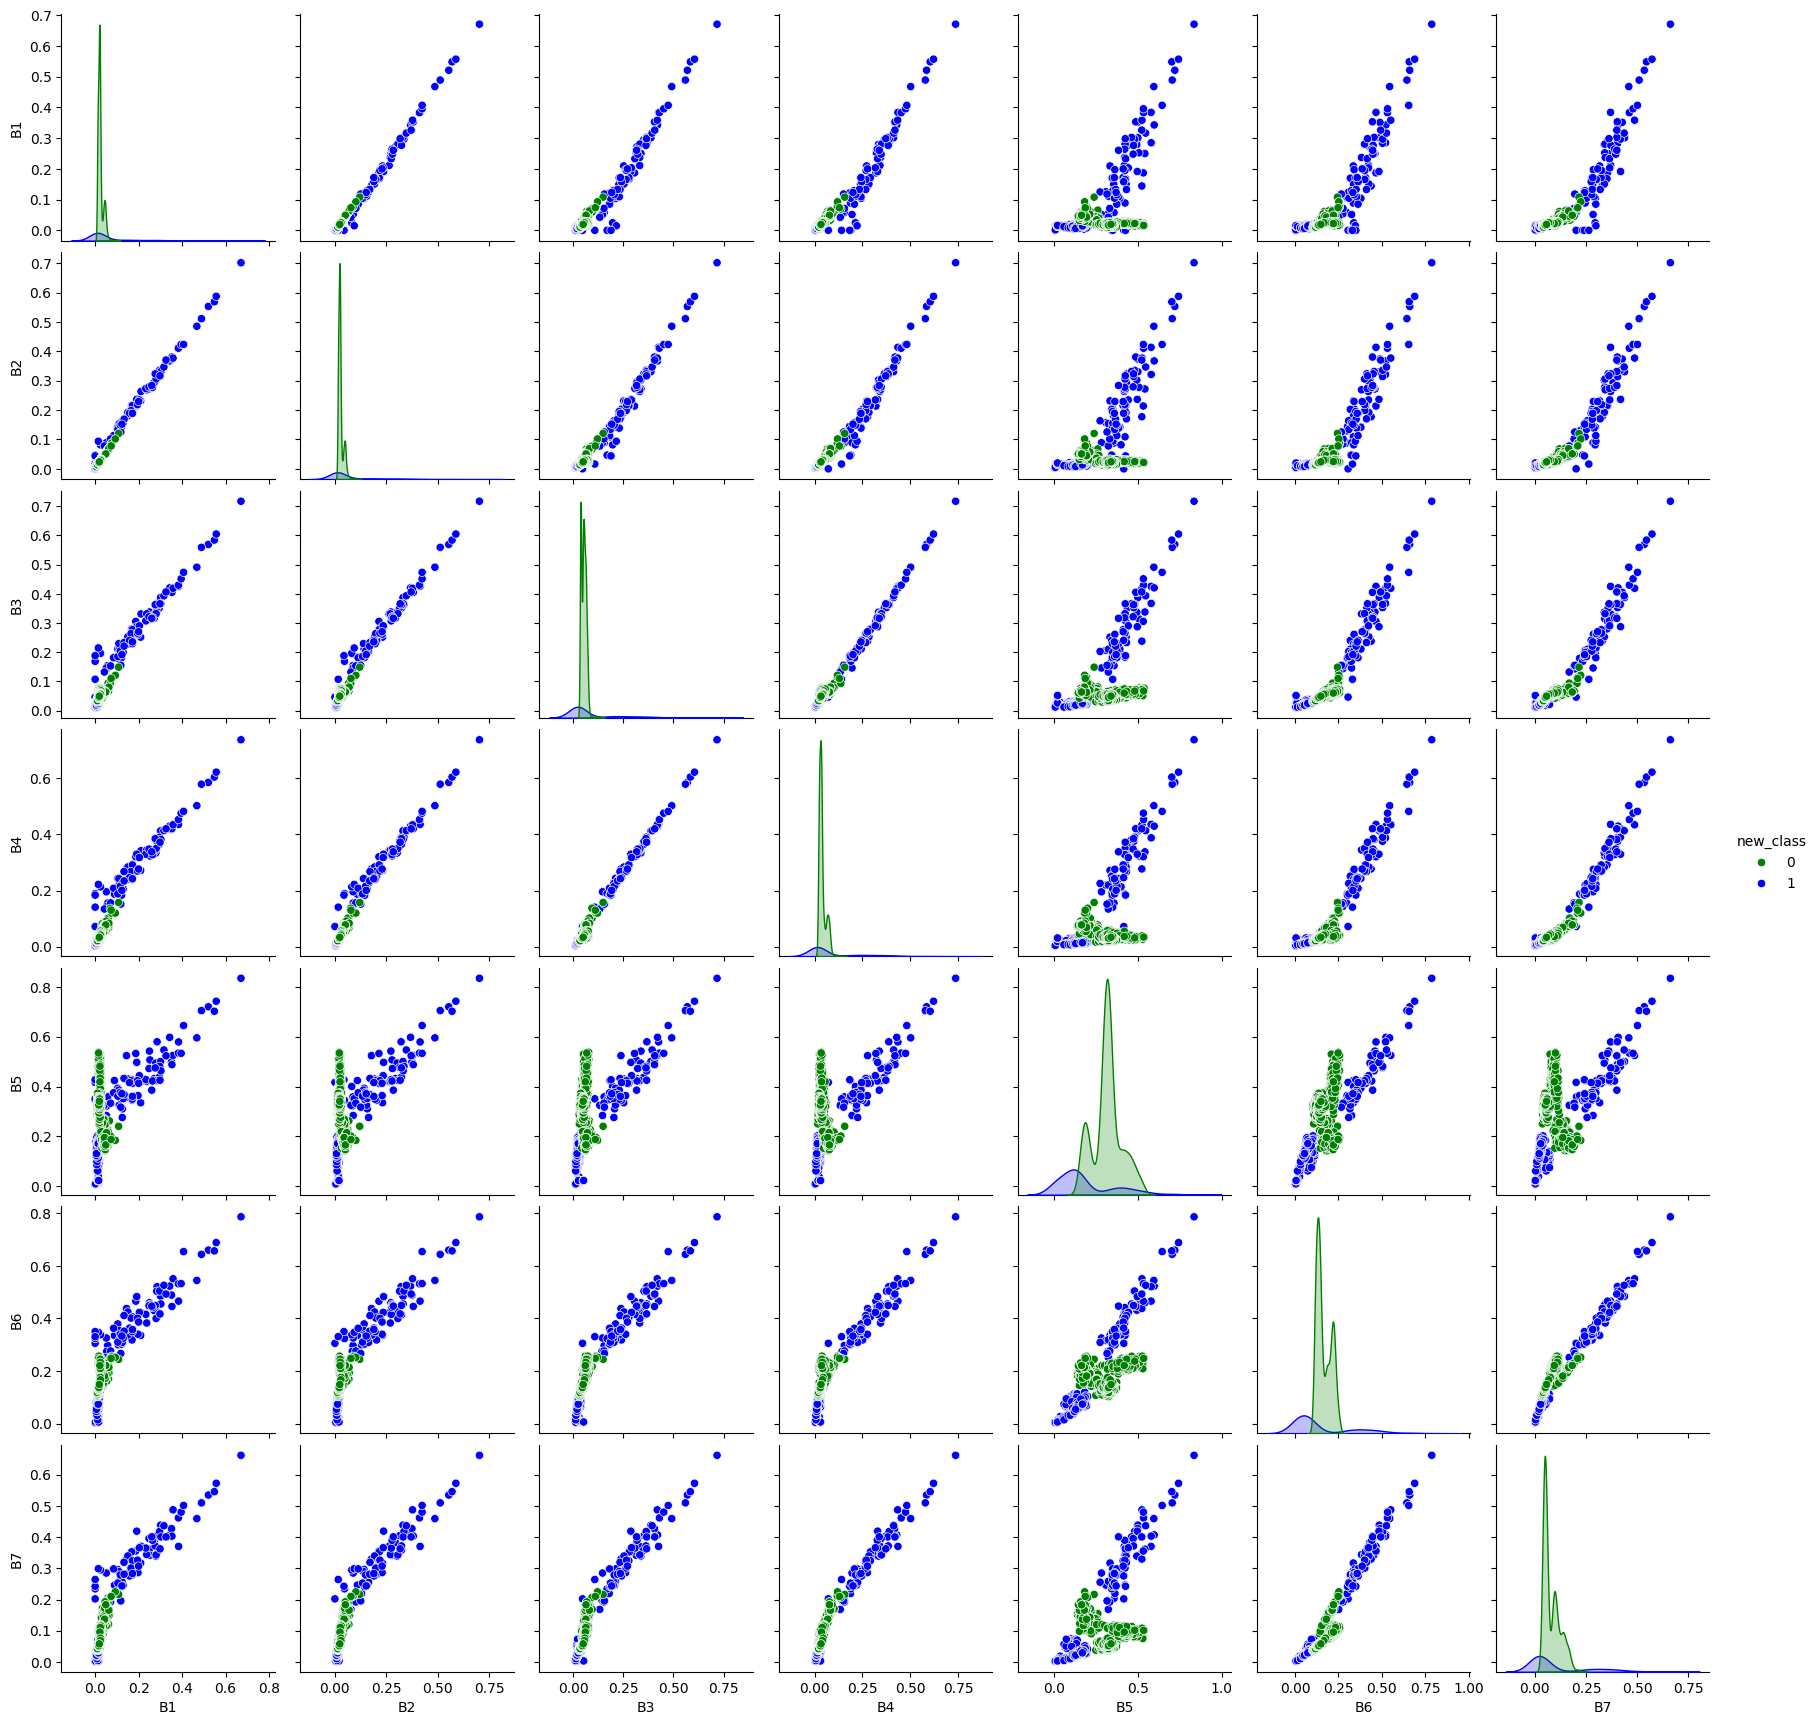

In [14]:
sns.pairplot(train_df, vars=train_df.columns[0:-2], hue='new_class', palette={1: 'blue', 0: 'green'})

In [15]:
X = train_df.drop(['class', 'new_class'], axis=1)
y = train_df['new_class']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [17]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=10, sampling_strategy='auto')),
    ('rf', RandomForestClassifier(random_state=10, class_weight='balanced'))
])

In [18]:
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}

In [19]:
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.2s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=10)),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=10))]),
             n_jobs=-1,
             param_grid={'rf__bootstrap': [True, False],
                         'rf__max_depth': [None, 10, 20, 30],
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [20]:
print("Best parameters found: ", grid_search.best_params_)
model_1 = grid_search.best_estimator_

Best parameters found:  {'rf__bootstrap': True, 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}


In [21]:
y_pred = model_1.predict(X_test)

In [22]:
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       241
           1       1.00      0.95      0.97        58

    accuracy                           0.99       299
   macro avg       0.99      0.97      0.98       299
weighted avg       0.99      0.99      0.99       299



In [23]:
accuracy_score(y_test, y_pred)

0.9899665551839465

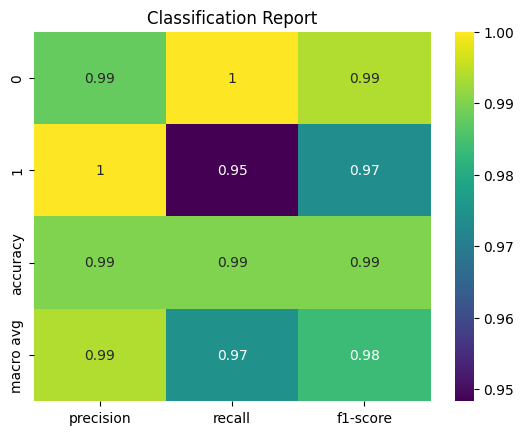

In [24]:
report_df = pd.DataFrame(report).transpose()

sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='viridis')
plt.title('Classification Report')
plt.show()

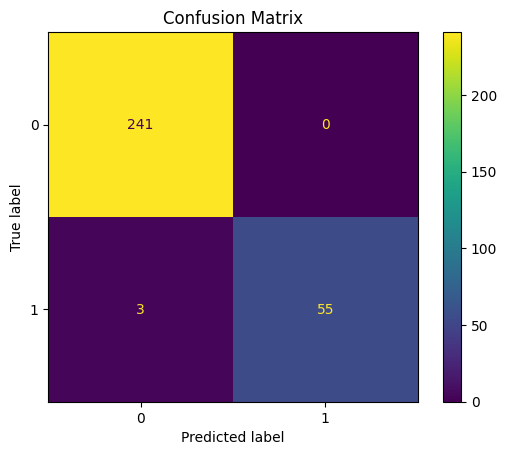

In [25]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_1.classes_)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

# Model 2: Awan VS Badan Air

In [26]:
train_2_df = train_df[train_df['new_class'] == 1]
train_2_df.head()

B1      B2      B3      B4      B5      B6      B7 class  new_class
0  0.5211  0.5531  0.5692  0.5852  0.7203  0.6603  0.5347  awan          1
1  0.4891  0.5115  0.5593  0.5788  0.7050  0.6441  0.5096  awan          1
2  0.6710  0.7020  0.7172  0.7371  0.8347  0.7871  0.6619  awan          1
3  0.5485  0.5690  0.5841  0.6042  0.7024  0.6574  0.5454  awan          1
4  0.3839  0.4138  0.4256  0.4356  0.5792  0.4661  0.3701  awan          1

In [27]:
train_2_df['class'].value_counts()

class
badan air    221
awan          80
Name: count, dtype: int64

In [28]:
train_2_df[train_2_df['class'] == 'awan']

B1      B2      B3      B4      B5      B6      B7 class  new_class
0   0.5211  0.5531  0.5692  0.5852  0.7203  0.6603  0.5347  awan          1
1   0.4891  0.5115  0.5593  0.5788  0.7050  0.6441  0.5096  awan          1
2   0.6710  0.7020  0.7172  0.7371  0.8347  0.7871  0.6619  awan          1
3   0.5485  0.5690  0.5841  0.6042  0.7024  0.6574  0.5454  awan          1
4   0.3839  0.4138  0.4256  0.4356  0.5792  0.4661  0.3701  awan          1
..     ...     ...     ...     ...     ...     ...     ...   ...        ...
75  0.1332  0.1689  0.2210  0.2343  0.3684  0.3517  0.2810  awan          1
76  0.1716  0.1890  0.2353  0.2421  0.3608  0.3580  0.2832  awan          1
77  0.1180  0.1254  0.1553  0.1518  0.3174  0.2668  0.1956  awan          1
78  0.1231  0.1521  0.1917  0.2006  0.3713  0.3331  0.2436  awan          1
79  0.4069  0.4236  0.4736  0.4820  0.6450  0.6546  0.5013  awan          1

[80 rows x 9 columns]

In [29]:
train_2_df[train_2_df['class'] == 'badan air']

B1      B2      B3      B4      B5      B6      B7      class  \
80   0.0143  0.0155  0.0271  0.0147  0.0194  0.0066  0.0033  badan air   
81   0.0141  0.0157  0.0264  0.0144  0.0182  0.0060  0.0034  badan air   
82   0.0102  0.0123  0.0251  0.0131  0.0163  0.0060  0.0032  badan air   
83   0.0050  0.0082  0.0216  0.0100  0.0140  0.0053  0.0027  badan air   
84   0.0120  0.0124  0.0248  0.0132  0.0159  0.0053  0.0027  badan air   
..      ...     ...     ...     ...     ...     ...     ...        ...   
296  0.0061  0.0077  0.0187  0.0110  0.1310  0.0545  0.0218  badan air   
297  0.0179  0.0175  0.0261  0.0162  0.1623  0.0932  0.0357  badan air   
298  0.0174  0.0176  0.0296  0.0182  0.1780  0.0762  0.0348  badan air   
299  0.0122  0.0120  0.0224  0.0124  0.1694  0.0718  0.0280  badan air   
300  0.0145  0.0132  0.0250  0.0141  0.1712  0.0739  0.0293  badan air   

     new_class  
80           1  
81           1  
82           1  
83           1  
84           1  
..         ...  
296          1  
297          1  
298          1  
299          1  
300          1  

[221 rows x 9 columns]

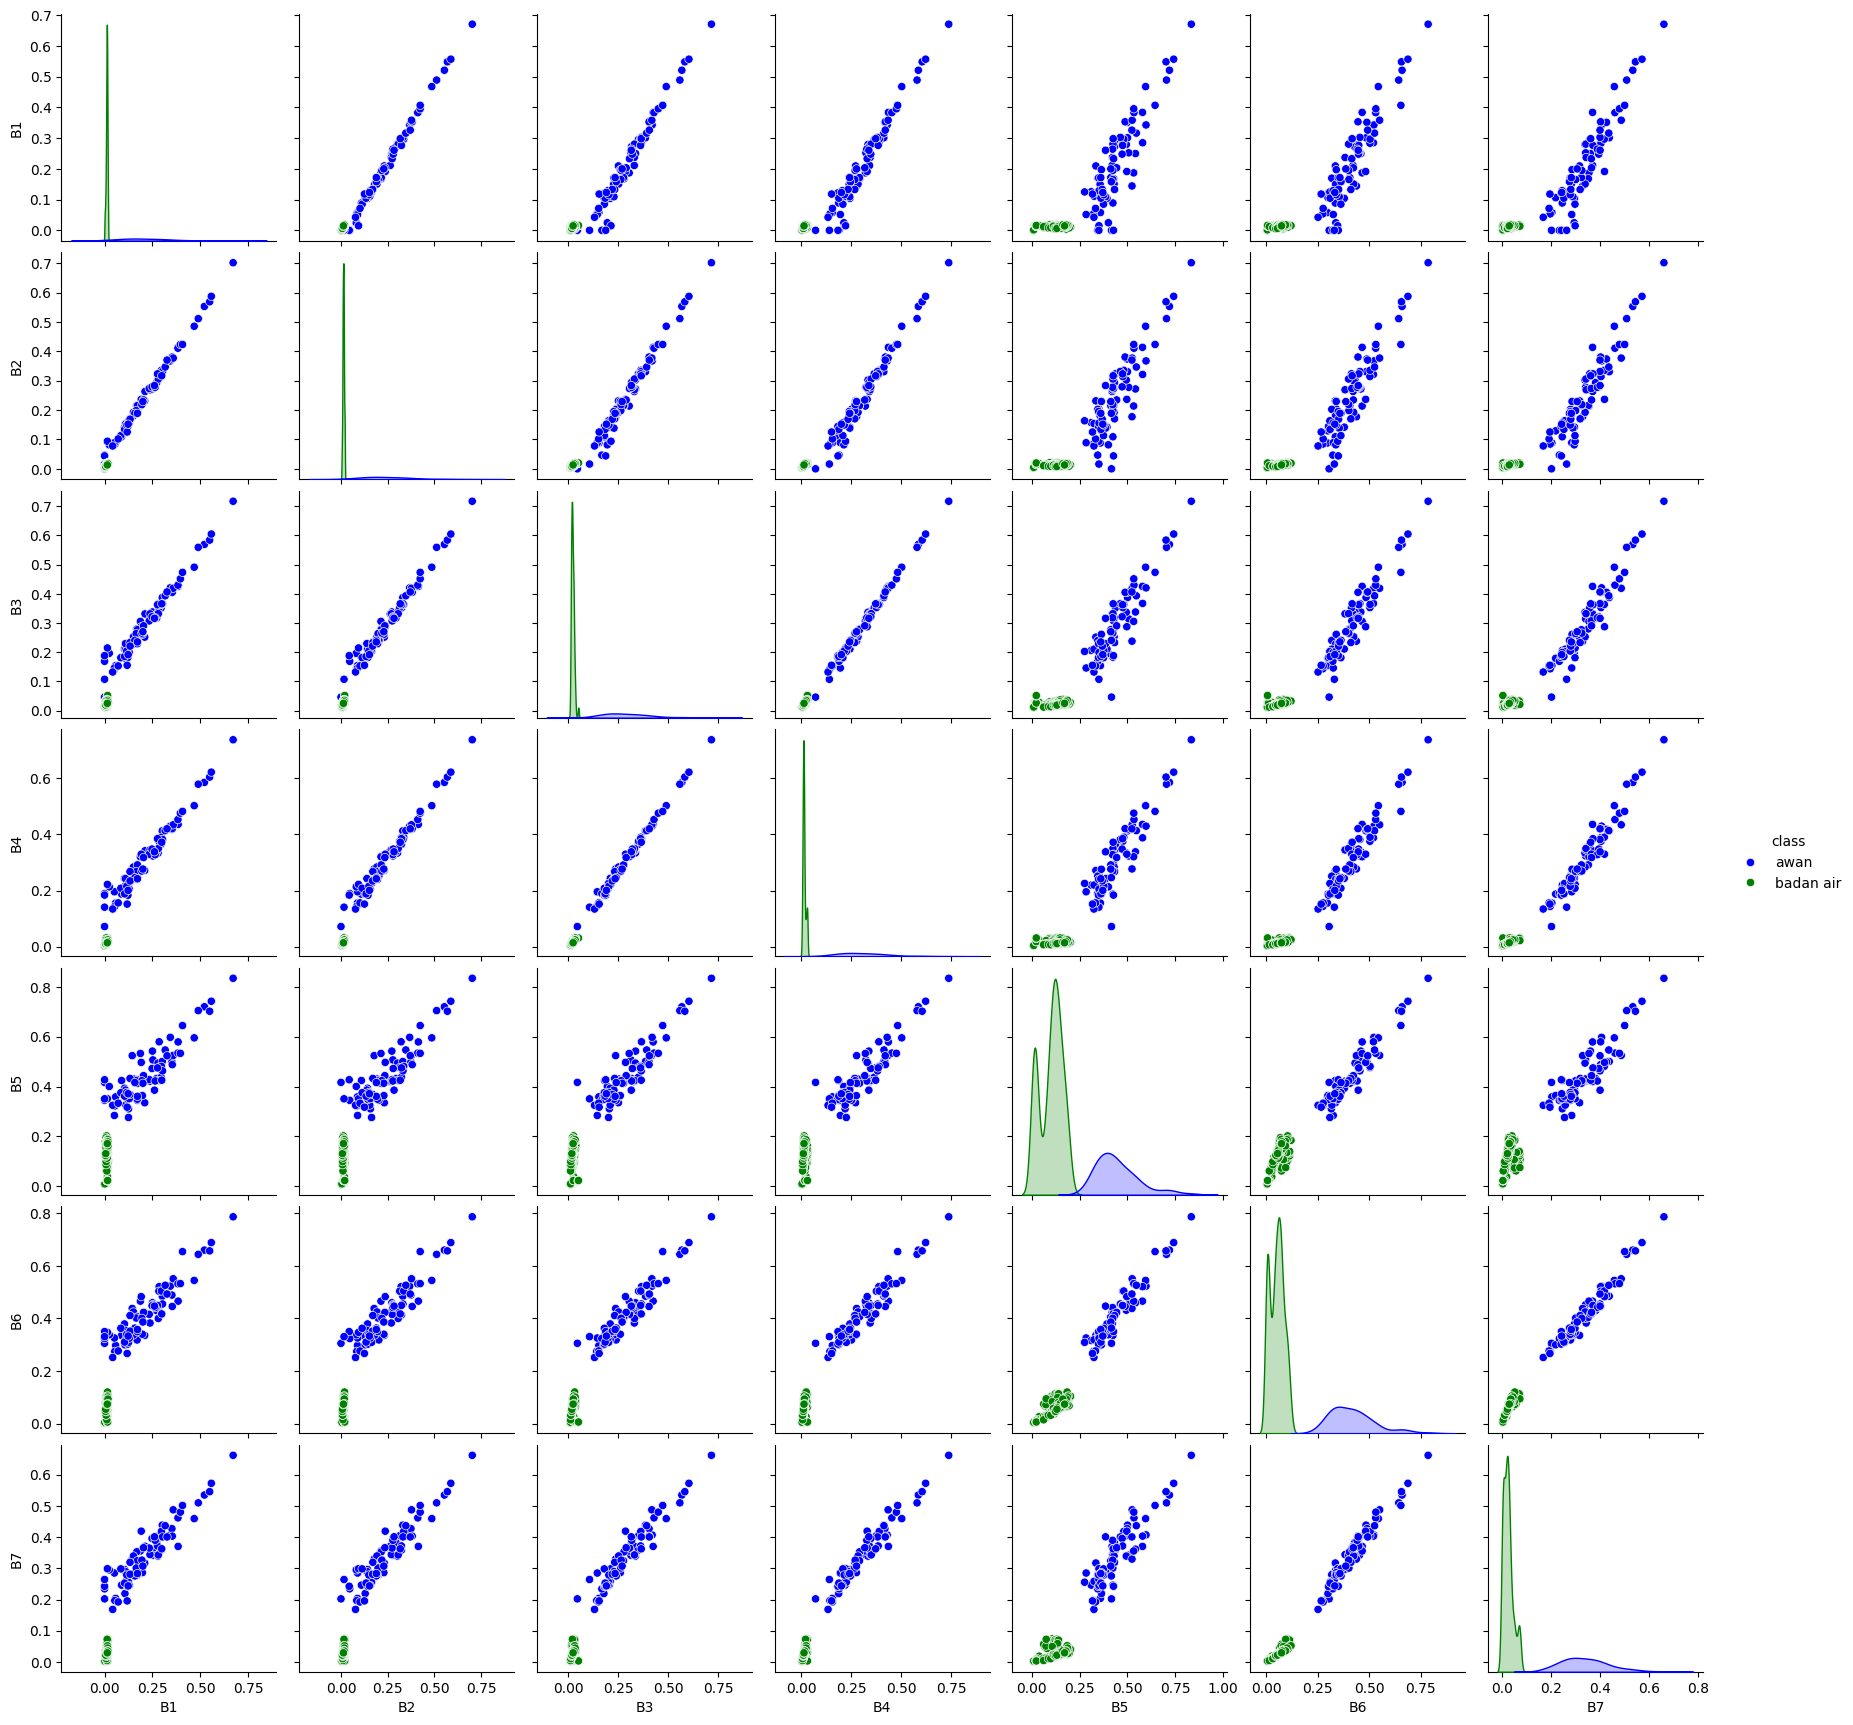

In [30]:
sns.pairplot(train_2_df, vars=train_2_df.columns[0:-2], hue='class', palette={'awan': 'blue', 'badan air': 'green'})

# Model 3: Perkebunan VS Pertanian VS Pemukiman VS Rerumputan

In [31]:
train_3_df = train_df[train_df['new_class'] == 0]
train_3_df.head()

B1      B2      B3      B4      B5      B6      B7      class  \
301  0.0365  0.0377  0.0555  0.0600  0.1879  0.1794  0.1312  pemukiman   
302  0.0345  0.0362  0.0515  0.0515  0.2151  0.1763  0.1170  pemukiman   
303  0.0298  0.0303  0.0462  0.0450  0.2208  0.1587  0.1094  pemukiman   
304  0.0345  0.0362  0.0515  0.0515  0.2151  0.1763  0.1170  pemukiman   
305  0.0421  0.0428  0.0574  0.0532  0.2191  0.1613  0.1104  pemukiman   

     new_class  
301          0  
302          0  
303          0  
304          0  
305          0

In [32]:
train_3_df['class'].value_counts()

class
perkebunan    379
pertanian     300
rerumputan    265
pemukiman     250
Name: count, dtype: int64

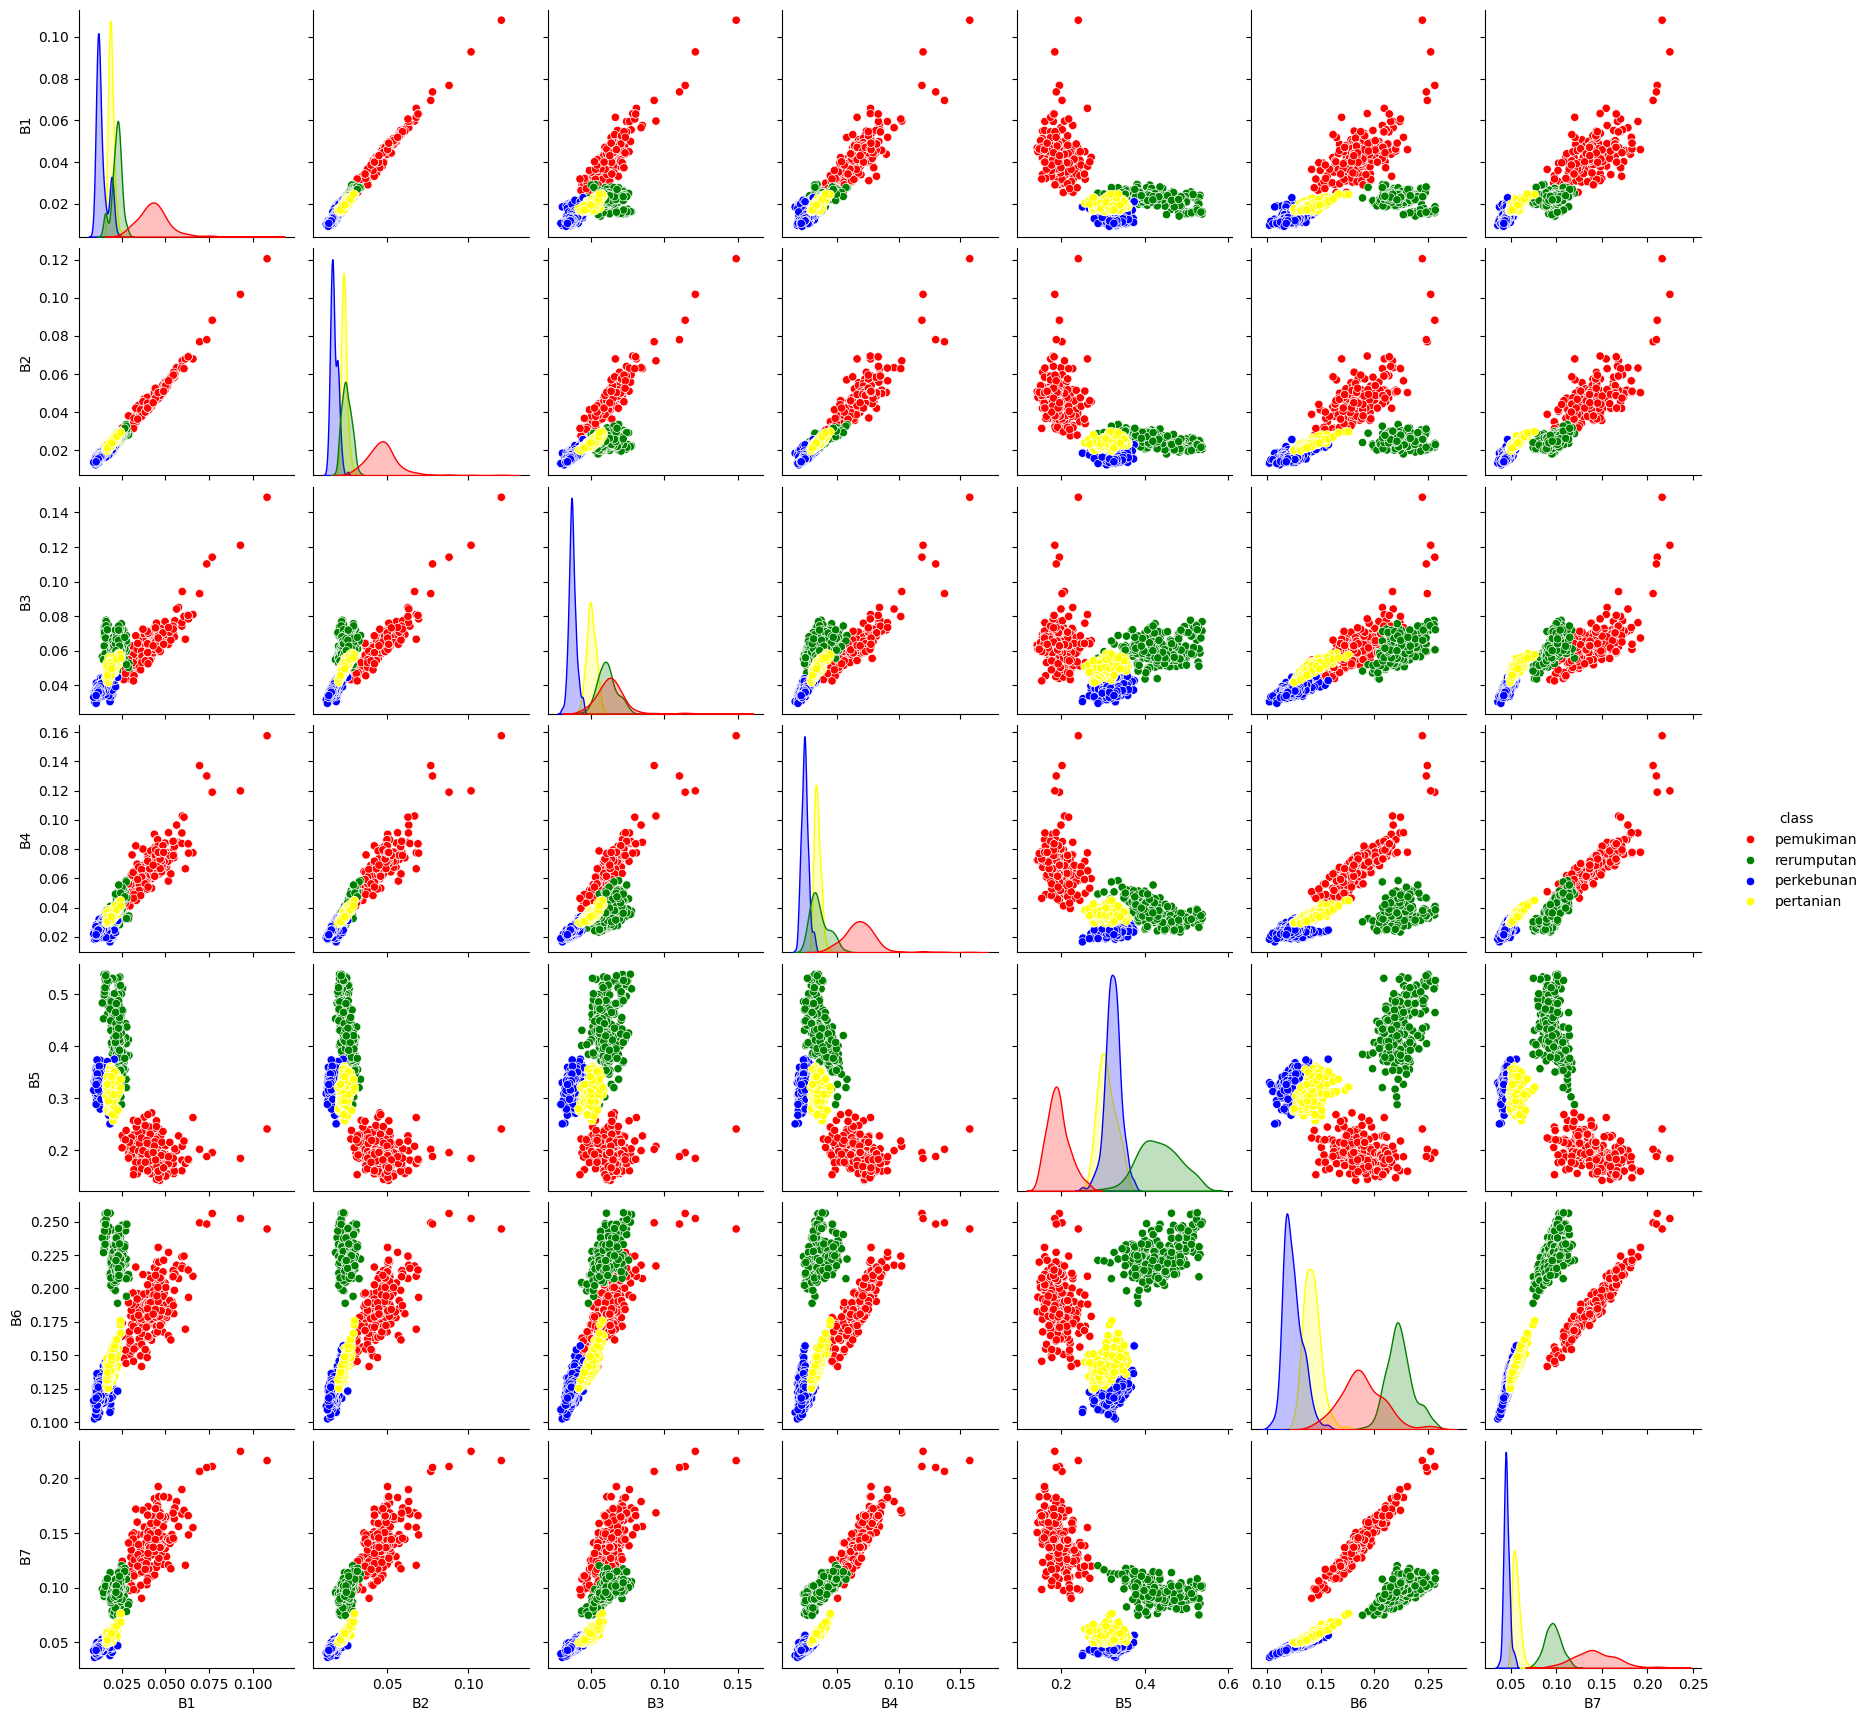

In [33]:
sns.pairplot(train_3_df, vars=train_3_df.columns[0:-2], hue='class', palette={'perkebunan': 'blue', 
                                                                              'pertanian': 'yellow',
                                                                              'pemukiman': 'red',
                                                                              'rerumputan': 'green'})

In [34]:
X = train_3_df.drop(['class', 'new_class'], axis=1)
y = train_3_df['class']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [36]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=10, sampling_strategy='auto')),
    ('rf', RandomForestClassifier(random_state=10, class_weight='balanced'))
])

In [37]:
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}

In [38]:
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=10)),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=10))]),
             n_jobs=-1,
             param_grid={'rf__bootstrap': [True, False],
                         'rf__max_depth': [None, 10, 20, 30],
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [39]:
print("Best parameters found: ", grid_search.best_params_)
model_3 = grid_search.best_estimator_

Best parameters found:  {'rf__bootstrap': True, 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}


In [40]:
y_pred = model_3.predict(X_test)

In [41]:
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   pemukiman       1.00      1.00      1.00        53
  perkebunan       1.00      1.00      1.00        80
   pertanian       1.00      1.00      1.00        59
  rerumputan       1.00      1.00      1.00        47

    accuracy                           1.00       239
   macro avg       1.00      1.00      1.00       239
weighted avg       1.00      1.00      1.00       239



In [42]:
accuracy_score(y_test, y_pred)

1.0

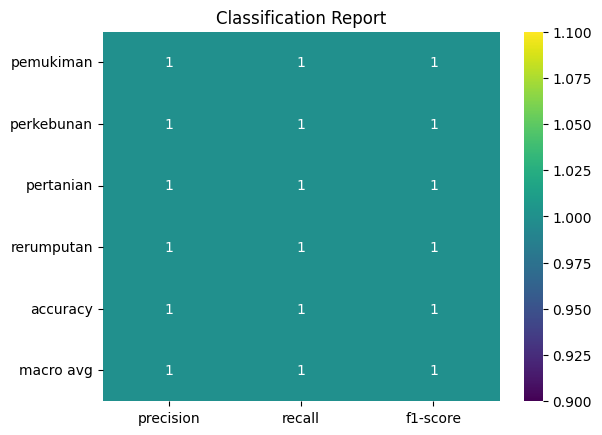

In [43]:
report_df = pd.DataFrame(report).transpose()

sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='viridis')
plt.title('Classification Report')
plt.show()

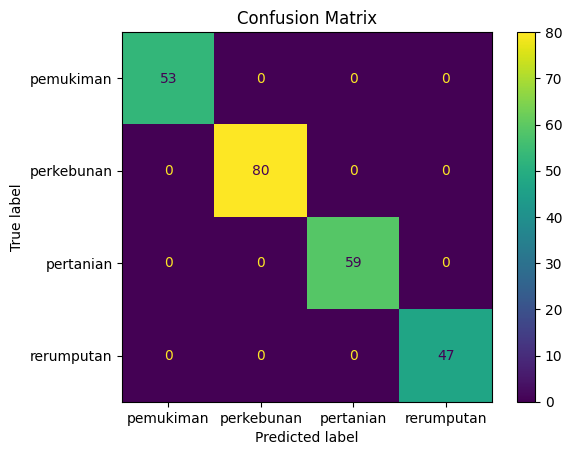

In [44]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_3.classes_)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

# Model 4: Perkebunan VS Pertanian VS Pemukiman VS Rerumputan VS Awan dan Badan Air

In [45]:
train_4_df = train_df[train_df['class'] != 'badan air'].copy()
train_4_df.head()

B1      B2      B3      B4      B5      B6      B7 class  new_class
0  0.5211  0.5531  0.5692  0.5852  0.7203  0.6603  0.5347  awan          1
1  0.4891  0.5115  0.5593  0.5788  0.7050  0.6441  0.5096  awan          1
2  0.6710  0.7020  0.7172  0.7371  0.8347  0.7871  0.6619  awan          1
3  0.5485  0.5690  0.5841  0.6042  0.7024  0.6574  0.5454  awan          1
4  0.3839  0.4138  0.4256  0.4356  0.5792  0.4661  0.3701  awan          1

In [46]:
train_4_df['class'] = np.where((train_4_df['class'] == 'awan' ), 'awan dan badan air', train_4_df['class'])
train_4_df['class'].value_counts()

class
perkebunan            379
pertanian             300
rerumputan            265
pemukiman             250
awan dan badan air     80
Name: count, dtype: int64

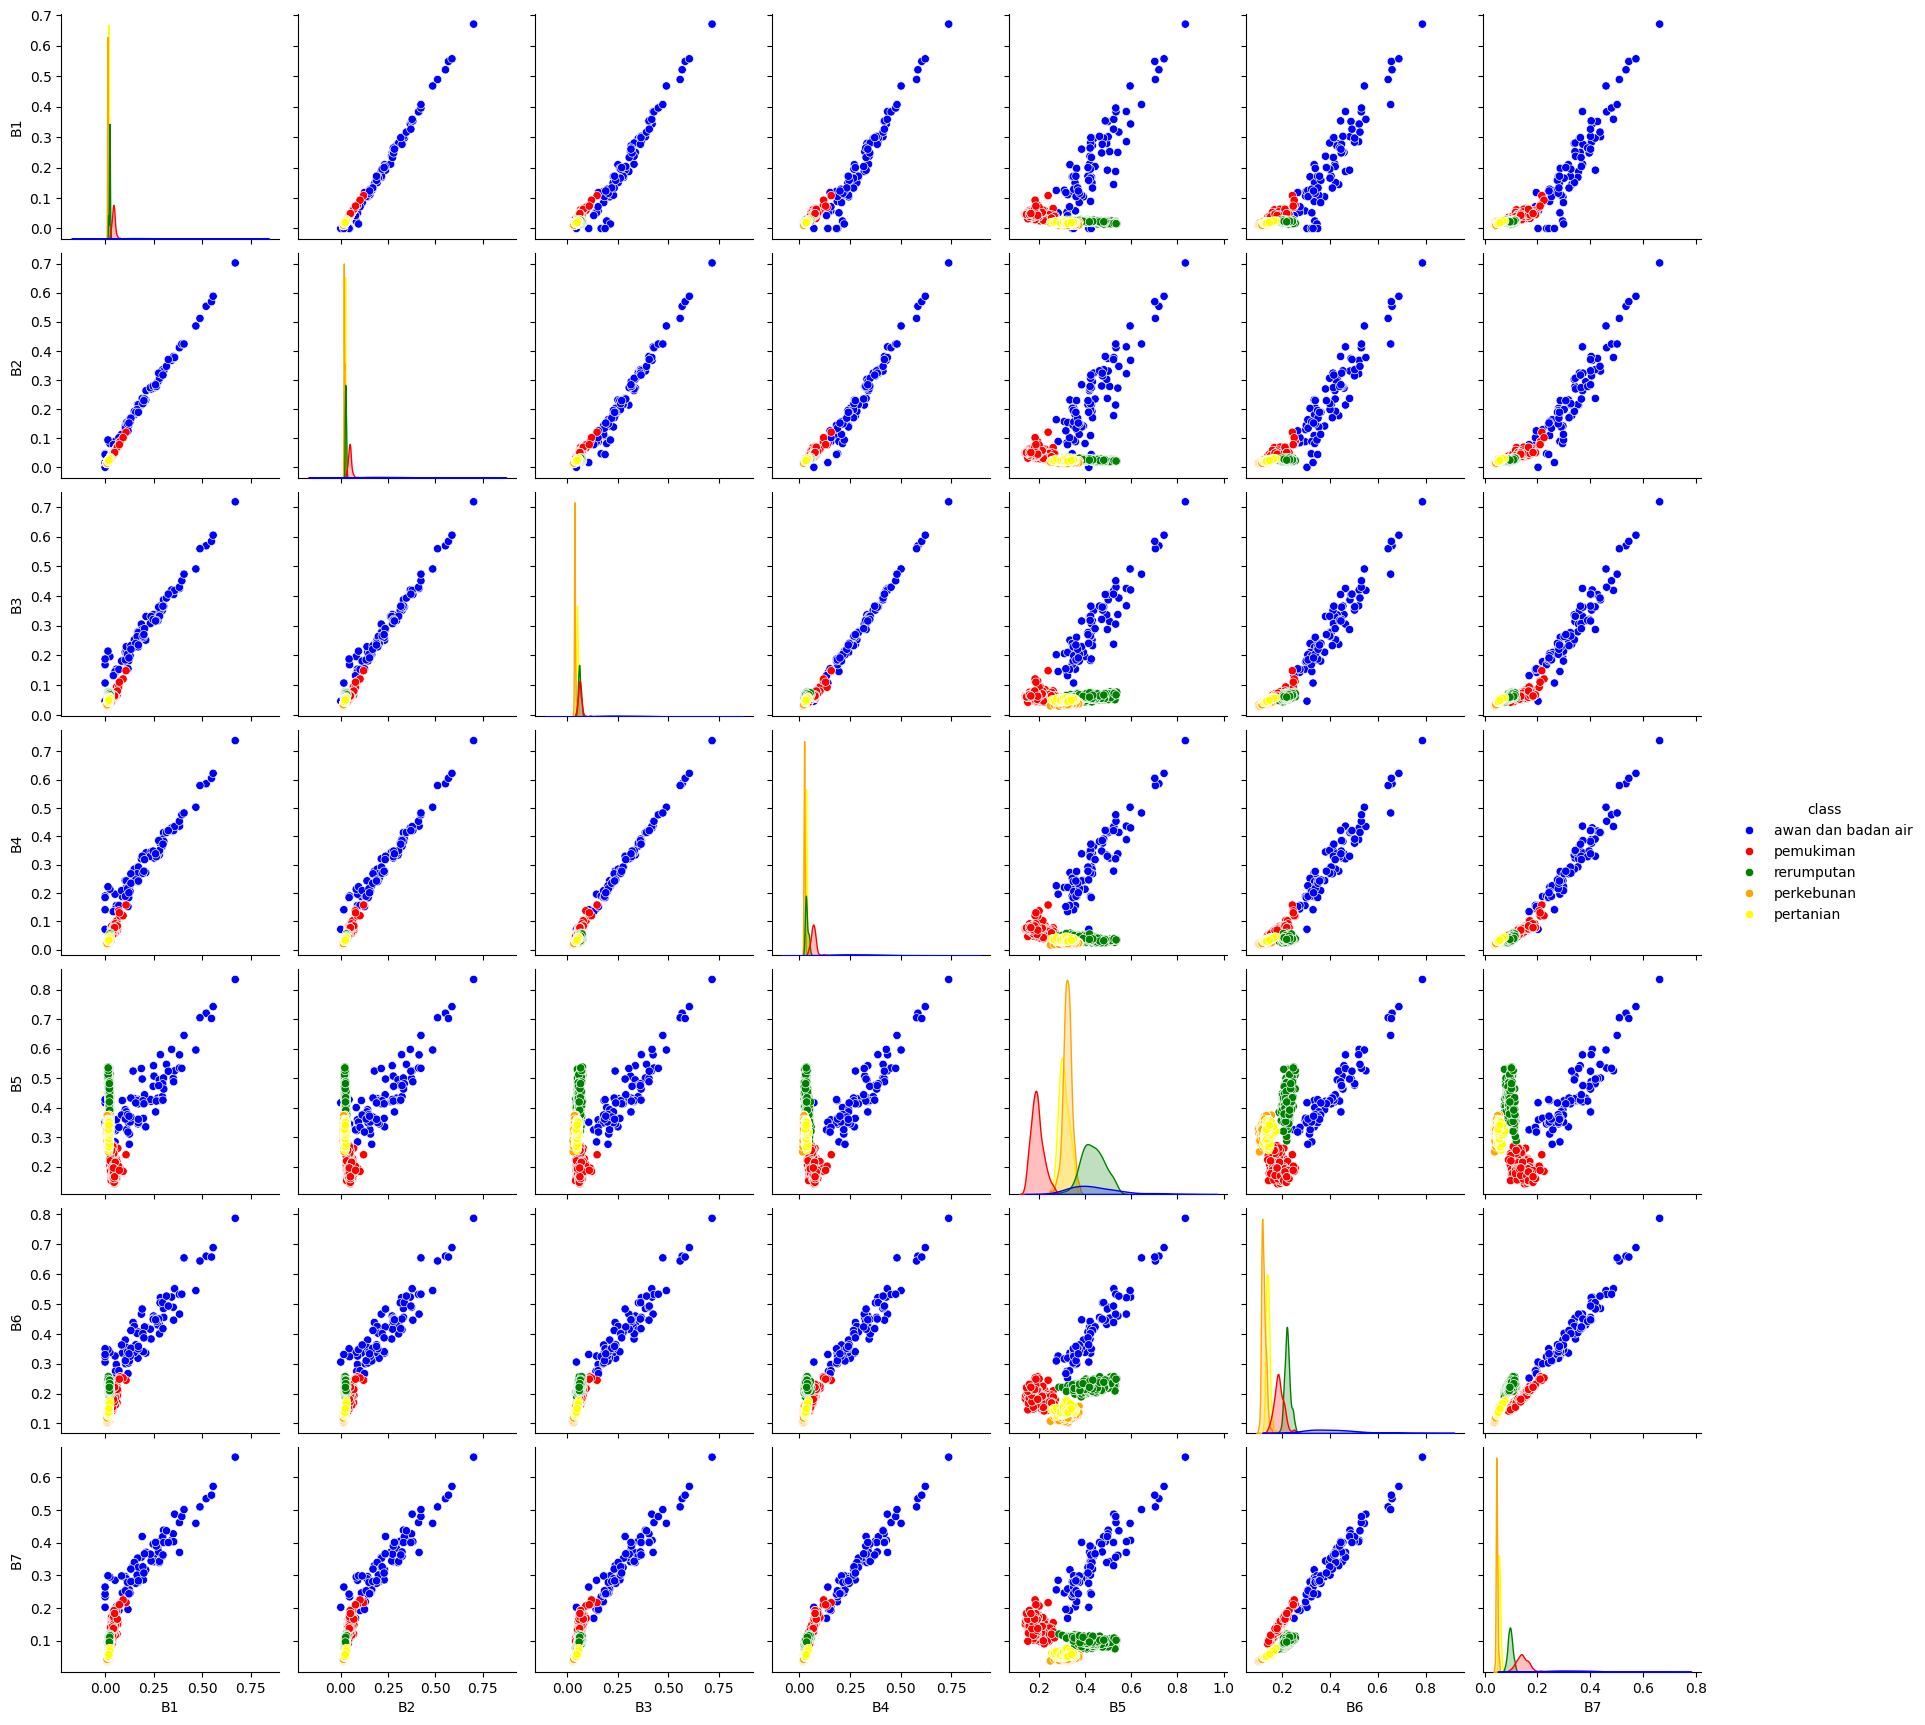

In [47]:
sns.pairplot(train_4_df, vars=train_4_df.columns[0:-2], hue='class', palette={'perkebunan': 'orange', 
                                                                              'pertanian': 'yellow',
                                                                              'pemukiman': 'red',
                                                                              'rerumputan': 'green',
                                                                              'awan dan badan air': 'blue'})

In [48]:
X = train_4_df.drop(['class', 'new_class'], axis=1)
y = train_4_df['class']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [50]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=10, sampling_strategy='auto')),
    ('rf', RandomForestClassifier(random_state=10, class_weight='balanced'))
])

In [51]:
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}

In [52]:
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n

/Users/miqbalshdq/Documents/Projects/Biomasa/venv/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=10)),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=10))]),
             n_jobs=-1,
             param_grid={'rf__bootstrap': [True, False],
                         'rf__max_depth': [None, 10, 20, 30],
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [53]:
print("Best parameters found: ", grid_search.best_params_)
model_4 = grid_search.best_estimator_

Best parameters found:  {'rf__bootstrap': True, 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}


In [54]:
y_pred = model_4.predict(X_test)

In [55]:
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

awan dan badan air       1.00      0.95      0.97        19
         pemukiman       1.00      1.00      1.00        48
        perkebunan       1.00      0.96      0.98        70
         pertanian       0.95      1.00      0.98        63
        rerumputan       0.98      1.00      0.99        55

          accuracy                           0.98       255
         macro avg       0.99      0.98      0.98       255
      weighted avg       0.98      0.98      0.98       255



In [56]:
accuracy_score(y_test, y_pred)

0.984313725490196

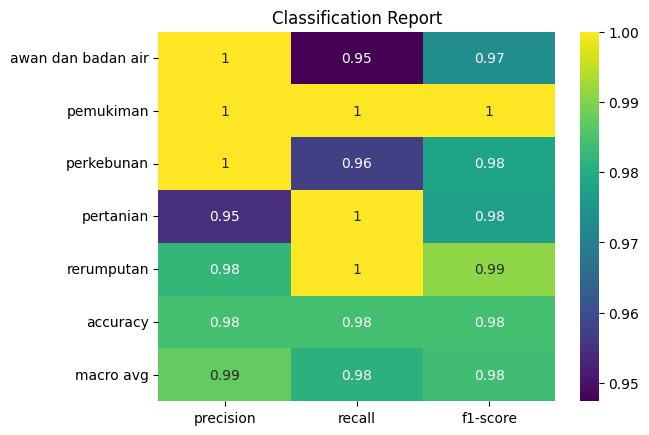

In [57]:
report_df = pd.DataFrame(report).transpose()

sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='viridis')
plt.title('Classification Report')
plt.show()

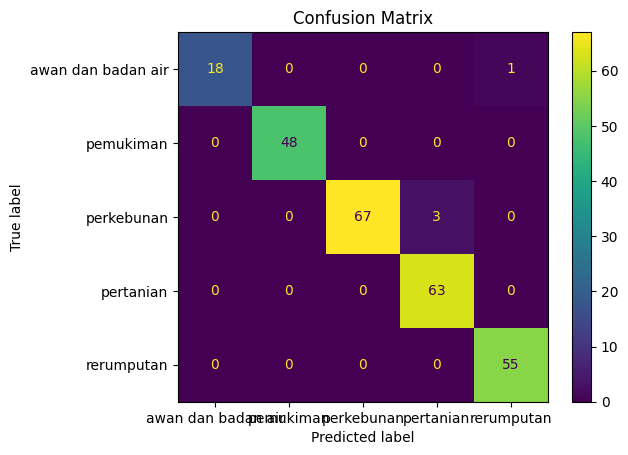

In [58]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_4.classes_)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

In [59]:
joblib.dump(model_4, '../models/best-model-4.joblib')

['../models/best-model-4.joblib']

# Model 5: Perkebunan VS Pertanian VS Pemukiman VS Rerumputan VS Awan VS Badan Air

In [60]:
train_5_df = train_df.copy()
train_5_df.head()

B1      B2      B3      B4      B5      B6      B7 class  new_class
0  0.5211  0.5531  0.5692  0.5852  0.7203  0.6603  0.5347  awan          1
1  0.4891  0.5115  0.5593  0.5788  0.7050  0.6441  0.5096  awan          1
2  0.6710  0.7020  0.7172  0.7371  0.8347  0.7871  0.6619  awan          1
3  0.5485  0.5690  0.5841  0.6042  0.7024  0.6574  0.5454  awan          1
4  0.3839  0.4138  0.4256  0.4356  0.5792  0.4661  0.3701  awan          1

In [61]:
train_5_df.drop(columns=['new_class'], inplace=True)
train_5_df['class'].value_counts()

class
perkebunan    379
pertanian     300
rerumputan    265
pemukiman     250
badan air     221
awan           80
Name: count, dtype: int64

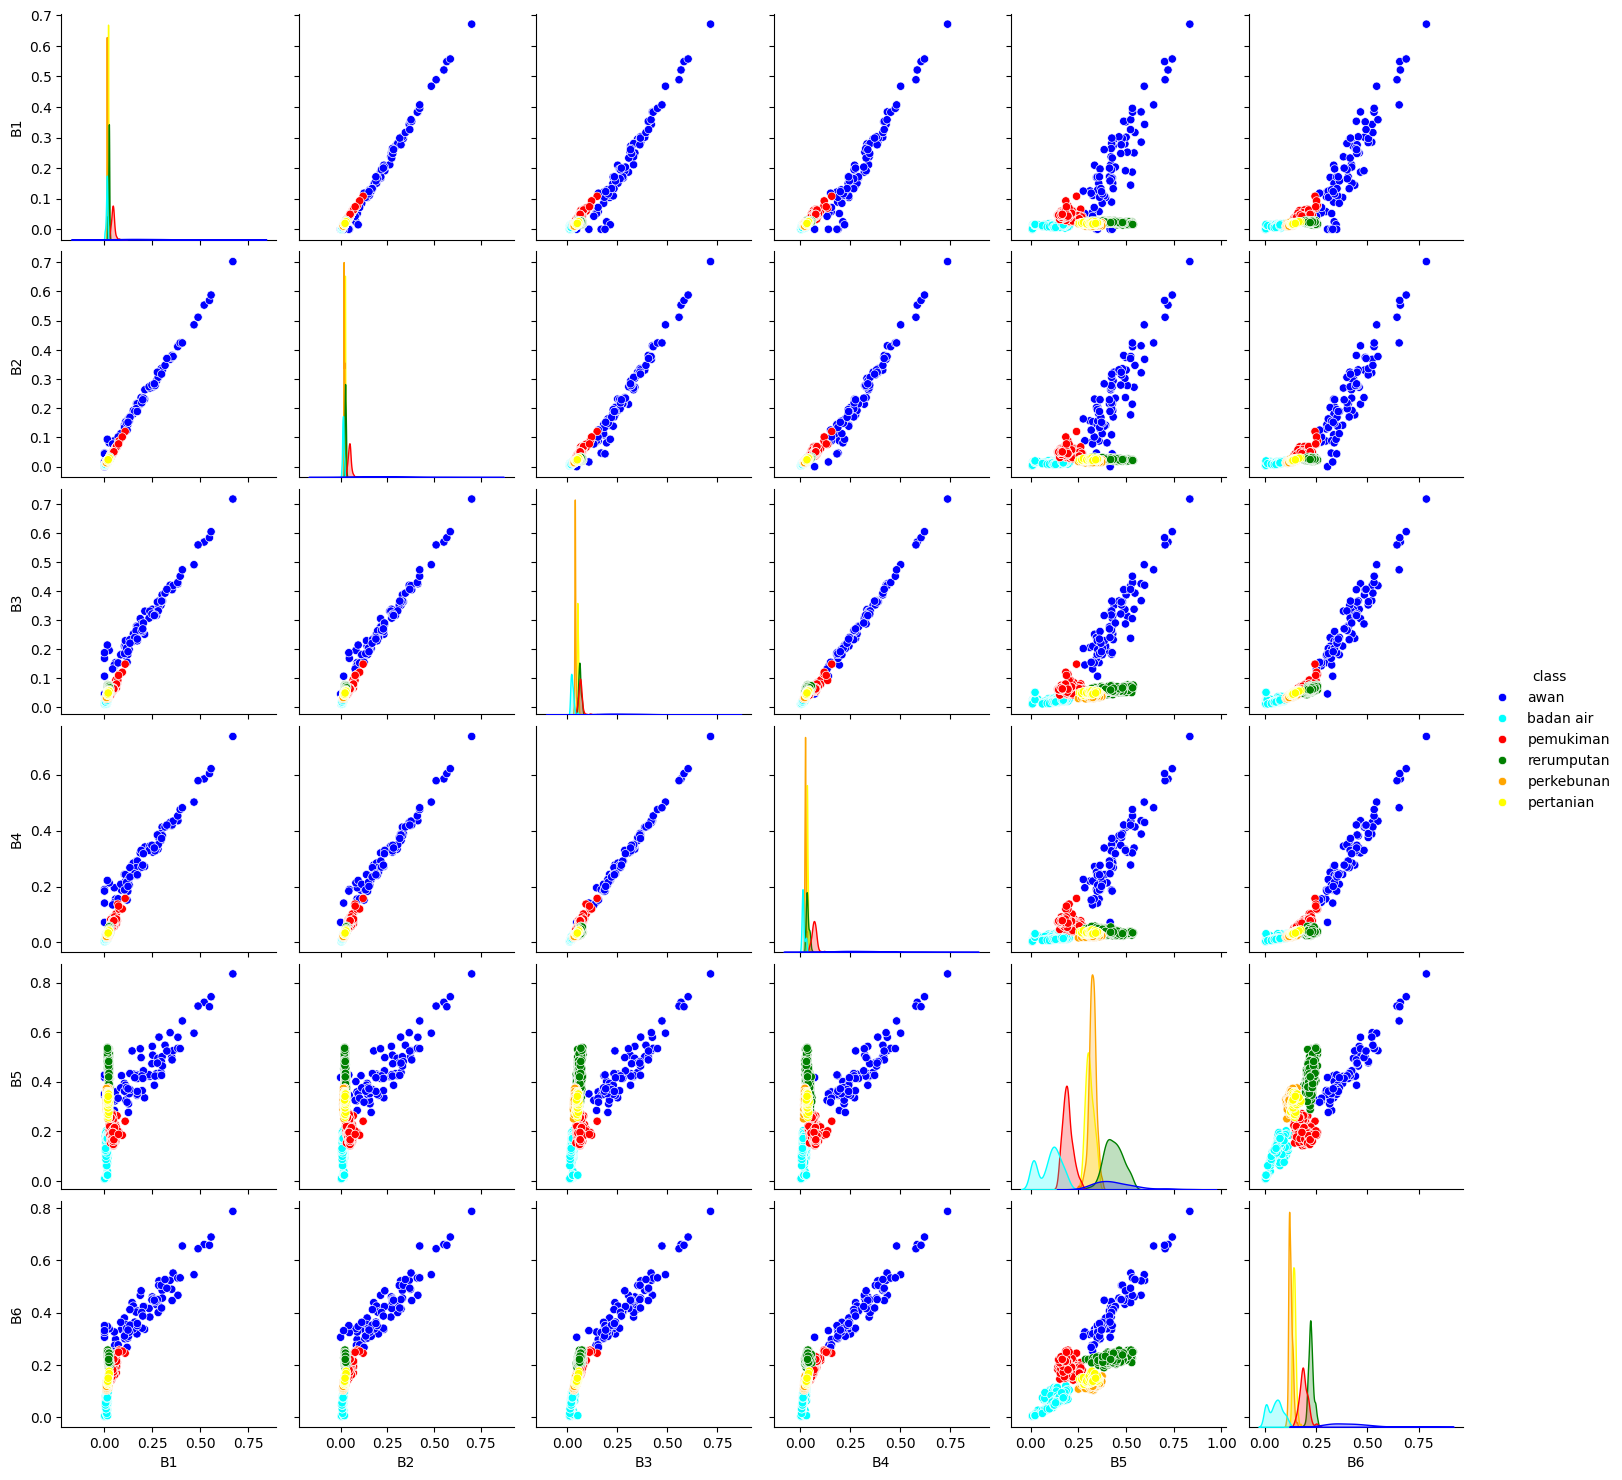

In [62]:
sns.pairplot(train_5_df, vars=train_5_df.columns[0:-2], hue='class', palette={'perkebunan': 'orange', 
                                                                              'pertanian': 'yellow',
                                                                              'pemukiman': 'red',
                                                                              'rerumputan': 'green',
                                                                              'awan': 'blue',
                                                                              'badan air': 'cyan'})

In [63]:
X = train_5_df.drop(['class'], axis=1)
y = train_5_df['class']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [65]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=10, sampling_strategy='auto')),
    ('rf', RandomForestClassifier(random_state=10, class_weight='balanced'))
])

In [66]:
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}

In [67]:
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.2s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n

/Users/miqbalshdq/Documents/Projects/Biomasa/venv/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=10)),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=10))]),
             n_jobs=-1,
             param_grid={'rf__bootstrap': [True, False],
                         'rf__max_depth': [None, 10, 20, 30],
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [68]:
print("Best parameters found: ", grid_search.best_params_)
model_5 = grid_search.best_estimator_

Best parameters found:  {'rf__bootstrap': True, 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}


In [69]:
y_pred = model_5.predict(X_test)

In [70]:
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        awan       1.00      0.88      0.94        17
   badan air       1.00      1.00      1.00        41
   pemukiman       0.98      1.00      0.99        49
  perkebunan       0.96      1.00      0.98        76
   pertanian       1.00      0.96      0.98        70
  rerumputan       0.98      1.00      0.99        46

    accuracy                           0.98       299
   macro avg       0.99      0.97      0.98       299
weighted avg       0.98      0.98      0.98       299



In [71]:
accuracy_score(y_test, y_pred)

0.9832775919732442

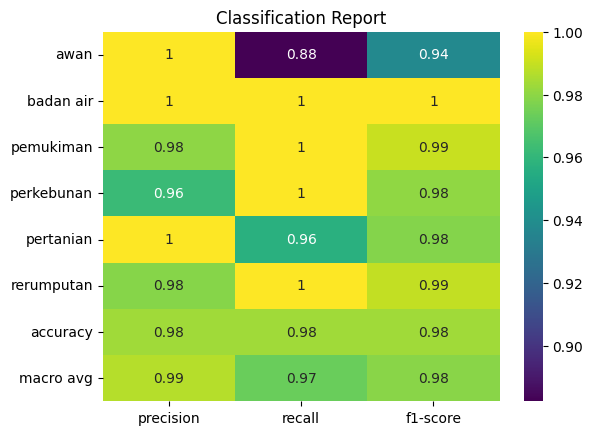

In [72]:
report_df = pd.DataFrame(report).transpose()

sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='viridis')
plt.title('Classification Report')
plt.show()

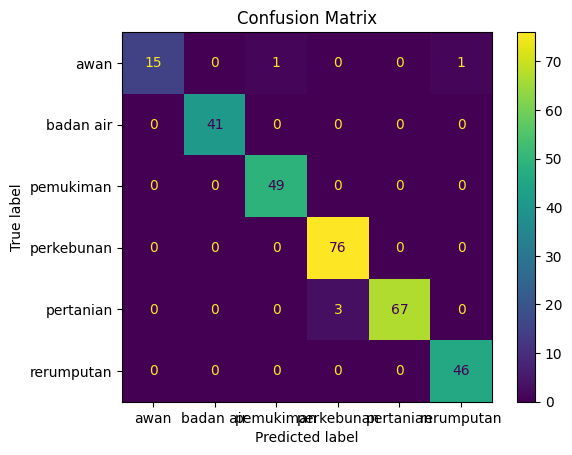

In [73]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_5.classes_)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

In [74]:
joblib.dump(model_5, '../models/best-model-5.joblib')

['../models/best-model-5.joblib']

# Apply to another image

In [75]:
class_mapping = {
    'perkebunan': 1,
    'pertanian': 2,
    'pemukiman': 3,
    'rerumputan': 4,
    'awan': 5,
    'badan air': 6,
    'no_data': 0
}

In [76]:
reverse_class_mapping = {v: k for k, v in class_mapping.items()}
reverse_class_mapping

{1: 'perkebunan',
 2: 'pertanian',
 3: 'pemukiman',
 4: 'rerumputan',
 5: 'awan',
 6: 'badan air',
 0: 'no_data'}

In [77]:
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        raster_data = src.read()
        profile = src.profile
        nodata = src.nodata
    return raster_data, profile, nodata

In [78]:
def write_raster(file_path, raster_data, profile, nodata_value):
    profile.update(dtype=rasterio.uint16 if nodata_value > 255 else rasterio.uint8, count=raster_data.shape[0], nodata=nodata_value)
    with rasterio.open(file_path, 'w', **profile) as dst:
        dst.write(raster_data)

In [79]:
def predict_raster(model, raster_data, nodata_value):
    n_bands, height, width = raster_data.shape
    reshaped_data = raster_data.reshape(n_bands, height * width).T 

    valid_mask = np.all(reshaped_data != nodata_value, axis=1)
    
    valid_data = reshaped_data[valid_mask] 

    predicted_classes = model.predict(valid_data)

    predicted_labels = np.array([class_mapping[pred] for pred in predicted_classes])

    predicted_raster = np.full((height, width), nodata_value, dtype=np.uint16)
    predicted_raster.flat[valid_mask] = predicted_labels
    
    return predicted_raster

In [80]:
input_raster = '../datasets/landsat8/Raster_L8_2020-06-13.tif'
output_raster = '../results/Raster_L8_2020-06-13_predicted.tif'

In [81]:
raster_data, profile, nodata_value = read_raster(input_raster)
predicted_raster = predict_raster(model_5, raster_data, nodata_value)
combined_raster = np.vstack([raster_data, predicted_raster[np.newaxis, :, :]])
profile.update(count=combined_raster.shape[0])
write_raster(output_raster, combined_raster, profile, nodata_value)

RasterioIOError: ../datasets/landsat8/Raster_L8_2020-06-13.tif: No such file or directory